# AML Challenge 2 Baseline Solution

This notebook is based on the Github [respository](https://github.com/daisukelab/dcase2020_task2_variants). 

We replicate the (Variational Auto-Encoder) VAE method for this AML challenge 2 which is a small scale of the official DCASE challenge [task 2](https://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds). 

# Required Python Packages

Let's install some python packages used in this notebook.

In [124]:
!pip install torchsummary
!pip install dl-cliche

In [125]:
pip install pytorch-lightning==1.9.5

Note: you may need to restart the kernel to use updated packages.


To import our own functions, you could upload the .py files in the input folder and do as we do for the "common.py" and "pytorch_common.py" files.

In [126]:
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/dcase2020-task2-baseline/pytorch_common.py", dst = "../working/pytorch_common.py")
copyfile(src = "../input/dcase2020-task2-baseline/common.py", dst = "../working/common.py")

# import all our functions
import common as com
import pytorch_common
from pytorch_common import *

# public modules
import torch
import torch.nn.functional as F
import torchsummary
import pytorch_lightning as pl
import random
import common as com
import librosa
import os
import glob
import csv
import re
import itertools
import sys
import path
import numpy
import seaborn as sns
from torch import nn
from tqdm import tqdm
from sklearn import metrics
from dlcliche.utils import *
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)

# Data Exploration

How many samples included?

How are the raw wave files?

How are the log mel spectrogram of the wave files?

Machine types: ['slider']


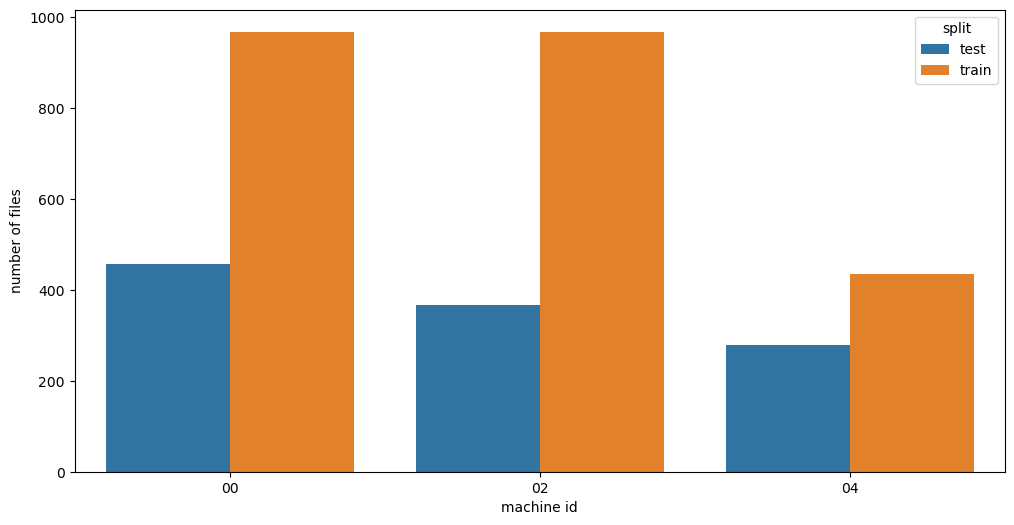

id      00         02         04      
split test train test train test train
file   456   968  367   968  278   434
type   456   968  367   968  278   434

In [127]:
# development dataset
DATA_ROOT=Path("../input/eurecom-aml-2023-challenge-2/dev_data/dev_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df = pd.DataFrame()
df['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df['type'] = df.file.map(lambda f: f.parent.parent.name)
df['split'] = df.file.map(lambda f: f.parent.name)
df['id'] = df.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

In [128]:
df_train=df[df.split=='train']
df_test=df[df.split=='test']

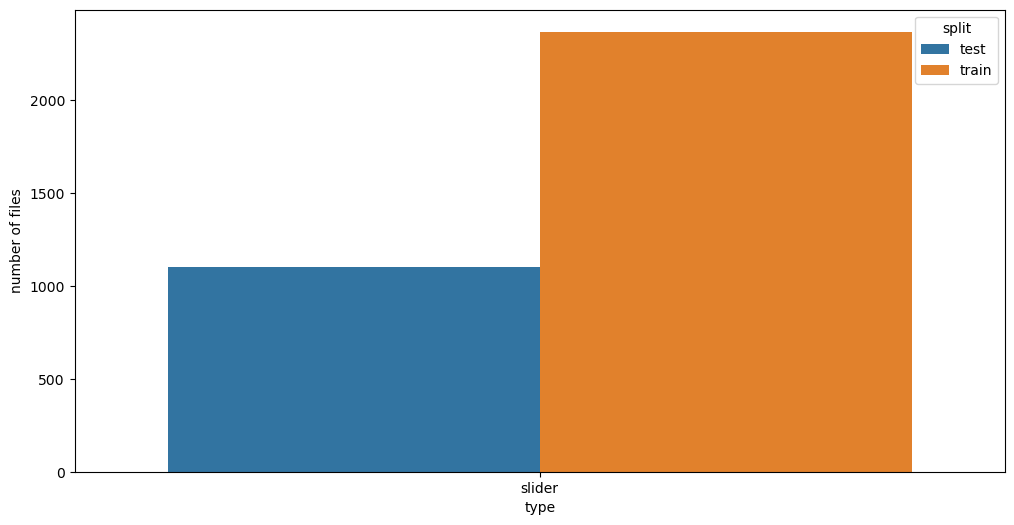

type  slider      
split   test train
file    1101  2370

In [129]:
agg = df[['file', 'type', 'split']].groupby(['type', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="type", y="file", hue="split", data=agg.reset_index())
plt.ylabel("machine type")
plt.ylabel("number of files")
plt.show()
agg.transpose()

Machine types: ['slider']


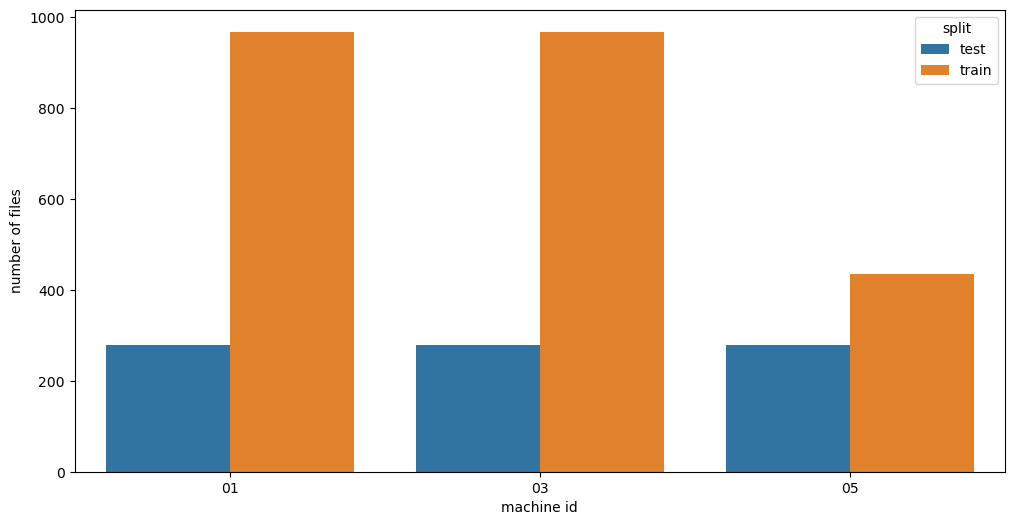

id      01         03         05      
split test train test train test train
file   278   968  278   968  278   434
type   278   968  278   968  278   434

In [130]:
# evaluation dataset
DATA_ROOT=Path("../input/eurecom-aml-2023-challenge-2/eval_data/eval_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df = pd.DataFrame()
df['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df['type'] = df.file.map(lambda f: f.parent.parent.name)
df['split'] = df.file.map(lambda f: f.parent.name)
df['id'] = df.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

=== Machine type [slider], train set ===


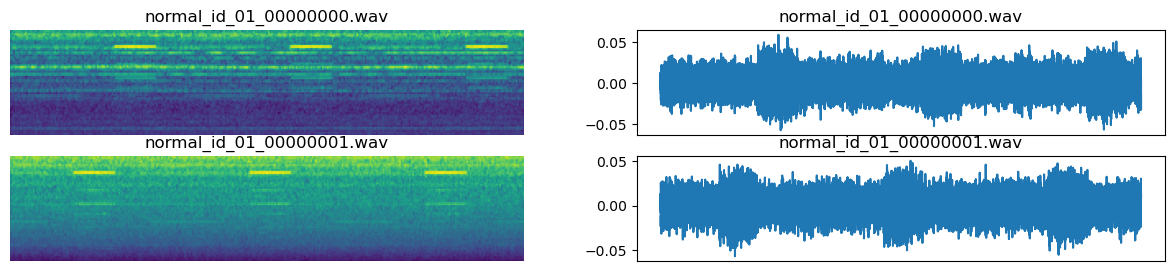

=== Machine type [slider], test set ===


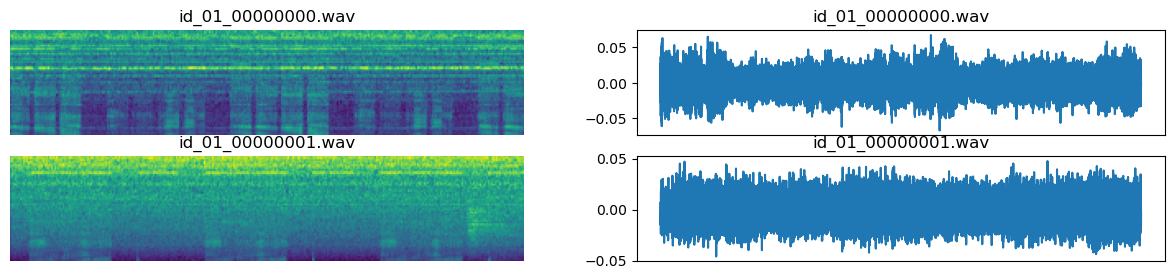

In [131]:
def get_log_mel_spectrogram(filename, n_mels=64,
                        n_fft=1024,
                        hop_length=512,
                        power=2.0):
    wav, sampling_rate = com.file_load(filename)
    mel_spectrogram = librosa.feature.melspectrogram(y=wav,
                                                     sr=sampling_rate,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
    return log_mel_spectrogram, wav

for t in types:
    for split in ['train', 'test']:
        type_df = df[df['type'] == t][df.split == split].reset_index()
        R = 2
        fig, ax = plt.subplots(R, 2, figsize = (15, 1.5*R))
        print(f'=== Machine type [{t}], {split} set ===')
        for i in range(R * 2):
            file_index = i//2
            file_path = Path(type_df.file[file_index])
            mels, wav = get_log_mel_spectrogram(file_path)
            if i%2==0:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].imshow(mels)
                ax[i//2, i%2].axis('off')
            else:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].plot(wav)
                ax[i//2, i%2].get_xaxis().set_ticks([])
        plt.show()

The raw audio file is a time-series data which indicates the amplitude of the sound over time (right figures). 

However, deep learning models rarely take this raw audio directly as input, the common practice is to convert the audio into a spectrogram (left figures). The spectrogram is a concise ‘snapshot’ of an audio wave and since it is an image, it is well suited to being input to CNN-based architectures developed for handling images. If you want to understand the audio spectrogram, this Audio Deep Learning [series](https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504) is very useful. In this notebook, we use the spectrogram as input.

# Network

The implementation of the Convolutional Auto-Encoder model (CNNAE).

In [132]:
class CNNAE(nn.Module):
    """
    This code is mostly taken from the suggested CNN baseline https://github.com/daisukelab/dcase2020_task2_variants
    """

    def  __init__(self, z_dim=40, skip_connections=False):
        super().__init__()
        self.skip_connections = skip_connections
        # encoder
        self.conv1 = nn.Sequential(nn.ZeroPad2d((1,2,1,2)), # left right top botttom
                                   nn.Conv2d(1, 32, kernel_size=5, stride=2),
                                  nn.ReLU())

        self.conv2 = nn.Sequential(nn.ZeroPad2d((1,2,1,2)),
                                  nn.Conv2d(32, 64, kernel_size=5, stride=2),
                                  nn.ReLU(),
                                  nn.Dropout(0.2))

        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
                                   nn.ReLU(),
                                   nn.Dropout(0.3))

        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),
                                  nn.ReLU(),
                                  nn.Dropout(0.3))

        self.fc1 = nn.Conv2d(256, z_dim, kernel_size=3)
        
        if self.skip_connections:
            # decoder
            self.fc2 = nn.Sequential(nn.ConvTranspose2d(z_dim, 256, kernel_size=3),
                                     nn.ReLU(),
                                     nn.Dropout(0.3))

            self.conv4d = nn.Sequential(nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
                                        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0),
                                        nn.ReLU(),
                                        nn.Dropout(0.3))

            self.conv3d = nn.Sequential(nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0),
                                        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
                                        nn.ReLU(),
                                        nn.Dropout(0.2))

            self.conv2d = nn.Sequential(nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
                                        nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
                                        nn.ReLU())

            self.conv1d = nn.Sequential(nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0),
                                        nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2))
        else:
            # no skip connections
            self.fc2 = nn.Sequential(nn.ConvTranspose2d(z_dim, 256, kernel_size=3),
                                     nn.ReLU(),
                                     nn.Dropout(0.3))

            self.conv4d = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0),
                                        nn.ReLU(),
                                        nn.Dropout(0.3))

            self.conv3d = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
                                        nn.ReLU(),
                                        nn.Dropout(0.2))

            self.conv2d = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
                                        nn.ReLU())

            self.conv1d = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2)

    def forward(self, x):
        if self.skip_connections:
            # encoder
            encoded = skip_1 = self.conv1(x)
            encoded = skip_2 = self.conv2(encoded)
            
            encoded = skip_3 = self.conv3(encoded)
            encoded = skip_4 = self.conv4(encoded)
            
            encoded = self.fc1(encoded)
            
            # decoder
            decoded = self.fc2(encoded)
            
            decoded = torch.cat([skip_4, decoded], dim=1)
            decoded = self.conv4d(decoded)
            
            decoded = torch.cat([skip_3, decoded], dim=1)
            decoded = self.conv3d(decoded)
           
            decoded = torch.cat([skip_2[:, :, :-1, :-1], decoded], dim=1)
            decoded = self.conv2d(decoded)            
            
            decoded = torch.cat([skip_1[:, :, :-1,:-1], decoded[:, :, 1:-1,1:-1]], dim=1)
            decoded = self.conv1d(decoded)[:,:,0:-1,0:-1]
            
            decoded = nn.Sigmoid()(decoded)
        else:
            encoded = self.conv1(x)
            encoded = self.conv2(encoded)
            encoded = self.conv3(encoded)
            encoded = self.conv4(encoded)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = self.conv4d(decoded)
            decoded = self.conv3d(decoded)
            decoded = self.conv2d(decoded)[:,:,1:-1,1:-1]
            decoded = self.conv1d(decoded)[:,:,0:-1,0:-1]

            decoded = nn.Sigmoid()(decoded)

        return decoded

# Parameters

In [152]:
params = {
# inout directory
"dev_directory" : "../input/eurecom-aml-2023-challenge-2/dev_data/dev_data/",
"eval_directory" : "../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/",
"model_directory": "./model",
"result_directory": "./result",
"result_file": "result.csv",
"max_fpr" : 0.1,
"mode" : True, # mode=True for development dataset, mode=False for evaluation dataset
"skip_connection": False,

# preprocessing for mel-spectrogram
"feature": {
"n_mels": 128, #64
"frames" : 5,
"n_fft": 1024,
"hop_length": 512,
"power": 2.0,
"random": True,  # apply random crop
"augment_tfm": None,  # Augument function
"augx": True, # augument input
"augy": True, # augument target
"debug": False, # print a couple of image after creation of dataset
"normalize": True  # Apply normalization
}, #2.0

## training
"fit":{
"lr": 0.001,
"b1": 0.9,
"b2": 0.99,
"weight_decay": 0.0,
"epochs" : 100,
"batch_size" : 256,
"shuffle" : True,
"validation_split" : 0.1,
"verbose" : 1,
"nu": None} 
    
}
params = EasyDict(params)

# create working directory
ensure_folder(params.model_directory)

types = ['slider']

# test directories
dirs = com.select_dirs(param=params, mode=params.mode)
print(dirs)

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data, types
slider_dir = dirs[0]
slider_dir

2023-05-30 14:43:21,634 - INFO - load_directory <- development
2023-05-30 14:43:21,634 - INFO - load_directory <- development
2023-05-30 14:43:21,634 - INFO - load_directory <- development
2023-05-30 14:43:21,634 - INFO - load_directory <- development
2023-05-30 14:43:21,634 - INFO - load_directory <- development
2023-05-30 14:43:21,634 - INFO - load_directory <- development
2023-05-30 14:43:21,634 - INFO - load_directory <- development


['/kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider']


'/kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider'

# Training

In [153]:
def list_to_vector_array_CNN(file_list,
                             n_mels=64,
                            n_fft=1024,
                            hop_length=512,
                            power=2.0
                            ):
    
    for idx, file in enumerate(file_list):
        log_mel_spect, _ = get_log_mel_spectrogram(file,
                                                n_mels=n_mels,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                power=power)

        if idx == 0:  # first file
            dataset = np.zeros(
                (len(file_list), 
                log_mel_spect.shape[0],
                log_mel_spect.shape[1])
            )
            com.logger.info(f'Created the  dataset shape ({dataset.shape})')
            dataset[idx, ...] = log_mel_spect
        else:
            dataset[idx, ...], _ = get_log_mel_spectrogram(file,
                                            n_mels=n_mels,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)
    return dataset

Dataset CNN

In [154]:
class DatasetCNN(torch.utils.data.Dataset):
    """
    most of the code is taken from the suggested baseline https://github.com/daisukelab/dcase2020_task2_variants

    This dataset is used to load the data for the CNN Auto Encoder

    For every output, this dataset class crop square image from this original data.

    Number of total samples is `n_sampling` times number of _live data_.
    _Live data_ is all the original data by default, and filtered by splitting functions.

    - For training use, set `random=True`. This will yield randomly cropped square
      image (64x64 for example) from the original sample (64x313 for 10s sample).
      
    - For validation use, set `random=False`. Image will be cropped from fixed position.

    Augmentation can be flexibly applied to either the output `x` only or `y` only, or both `x` and `y`.
    `aug_x` and `aug_y` control this behavor.

    Data split for training/validation can be done by using:
        `get_index_by_pct()`: generate list of training index.
        `train_split(train_index)`: set live data as original samples listed on `train_index`.
        `val_split(train_index)`: set live data as original samples NOT listed on `train_index`.
    Yields:
        x: square image expected to be used as source.
        y: square image expected to be used as reference for evaluating reconstructed image by training model.
    """

    def __init__(self,  files, n_mels, n_fft, hop_length, power,
                 n_sampling=10, transform=None, augment_tfm=None, normalize=True, 
                 random=True, aug_x=True, aug_y=True, debug=True):
        
        self.n_sampling = n_sampling
        self.files = files
        self.n_mels, self.n_fft = n_mels, n_fft
        self.hop_length, self.power = hop_length, power
        
        self.transform, self.augment_tfm = transform, augment_tfm
        self.random, self.aug_x, self.aug_y = random, aug_x, aug_y

        self.X = list_to_vector_array_CNN(self.files,
                                        n_mels=self.n_mels,
                                        n_fft=self.n_fft,
                                        hop_length=self.hop_length,
                                        power=self.power
                                        )
        
        if normalize:
            self.X = normalize_0to1(self.X)

        if debug:
            from dlcliche.utils import display
            from dlcliche.math import np_describe
            display(np_describe(self.X[0].cpu().numpy()))

        self.orgX = self.X
  
    def get_index_by_pct(self, split_pct=0.1):
        n = len(self.orgX)
        return random.sample(range(n), k=(n - int(n * split_pct)))

    def train_split(self, train_index):
        self.train_index = train_index
        self.X = self.orgX[train_index]
    
    def val_split(self, train_index):
        n = len(self.orgX)
        self.val_index = [i for i in range(n) if i not in train_index]
        self.X = self.orgX[self.val_index]

    def __len__(self):
        return len(self.X) * self.n_sampling

    def __getitem__(self, index):
        file_index = index // self.n_sampling
        part_index = index % self.n_sampling
        x = self.X[file_index]
        dim, length = x.shape

        # crop square part of sample
        if self.random:
            # random crop
            start = random.randint(0, length - dim)
        else:
            # crop with fixed position
            start = (length // self.n_sampling) * part_index
        start = min(start, length - dim)
        x = x[:, start:start+dim]

        # augmentation transform
        y = x
        if self.augment_tfm is not None:
            tfm_x = self.augment_tfm(x)
            if self.aug_x: x = tfm_x
            if self.aug_y: y = tfm_x

        # transform (convert to tensor here)
        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

CNN training class¶


In [155]:
def get_radius(dist: torch.Tensor, nu: float):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return np.quantile(np.sqrt(dist.clone().data.cpu().numpy()), 1 - nu)

def SVDD_loss_function(outputs, loss_objective, c, R, nu=0.1):
    """
    Params:
        recon_x: output of the VAE
        c: Hypersphere center
        loss_objective: 'one-class', 'soft-boundary'
        R: radius of the sphere
        
    """

    dist = torch.sum( (outputs - c) ** 2, dim=1)

    if loss_objective == 'soft-boundary':
        scores = dist - R ** 2
        loss = R ** 2 + (1 / nu) * torch.mean(
            torch.max( torch.zeros_like(scores),scores)
            )
    else:
        loss = torch.mean(dist)
    
    # Update R
    if (loss_objective == 'soft-boundary'):
        R = torch.tensor(get_radius(dist, nu), device=device) # Device set global 

    return loss, R

In [156]:
total_loss = []
total_val_loss = []

# CNN VA Training class
class CNNTraining(pl.LightningModule):
    """Task2 PyTorch Lightning class, for training only."""

    def __init__(self, device, model, params, files, normalize=False):
        super().__init__()
        self.nu = None
        self.params = params
        self.lr = params.fit.lr
        self.normalize = normalize
        self.model = model
        self.mseloss = torch.nn.MSELoss()
        
        # split data files
        if files is not None:
            n_val = int(params.fit.validation_split * len(files))
            self.val_files = random.sample(files, n_val)
            self.train_files = [f for f in files if f not in self.val_files]
        
        if params.fit.nu is not None:
            self.R = torch.tensor(0.0, device=device)
            self.nu = params.fit.nu
            
            # GET CENTER
            dl = self.train_dataloader()
            self.c = self.init_center_c(dl, model, device)
    
    
    def init_center_c(self,
                      train_loader, 
                  net: nn.Module,
                  device, 
                  eps: float=0.1):

        n_samples = 0
        net.eval()
        with torch.no_grad():
            for i, data in enumerate(train_loader):
                # get the inputs of the batch
                inputs, _ = data 
                inputs = inputs.to(device)
                outputs = net(inputs)
                outputs = outputs.to(device)
                n_samples += outputs.shape[0]
                if i == 0:
                    c = torch.zeros(outputs.shape[1:], device=device)
                c += torch.sum(outputs, dim=0)

        c /= n_samples

        # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c
       

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.mseloss(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
        
        total_loss.append(float(loss))
        
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss =  self.mseloss(y_hat, y)
        
        total_val_loss.append(float(loss))
        self.log("val_loss", float(loss))
        
        return {'val_loss': self.mseloss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),
                                lr=self.params.fit.lr,
                                betas=(self.params.fit.b1, self.params.fit.b2),
                                weight_decay=self.params.fit.weight_decay)

    def train_dataloader(self):
        com.logger.info('Creating Train')
        data_loader = self._get_dl('train')
        com.logger.info('End Train')
        return data_loader

    def val_dataloader(self):
        com.logger.info('Creating Val')
        data_loader = self._get_dl('val')
        com.logger.info('End Val')
        return data_loader
    
    
    def _get_dl(self, for_what):
        files = self.train_files if for_what == 'train' else self.val_files
        
        ds = DatasetCNN(files,
                        n_mels=self.params.feature.n_mels,
                        n_fft=self.params.feature.n_fft,
                        hop_length=self.params.feature.hop_length,
                        power=self.params.feature.power,
                        transform=ToTensor1ch(device=device, image=True),
                        random=self.params.feature.random,
                        augment_tfm=self.params.feature.augment_tfm,
                        aug_x=self.params.feature.augx,
                        aug_y=self.params.feature.augy,
                        debug=self.params.feature.debug,
                        normalize=self.params.feature.normalize)
    
        return torch.utils.data.DataLoader(ds,
                                           batch_size=self.params.fit.batch_size,
                                              shuffle=(self.params.fit.shuffle if for_what == 'train' else False)
                                          )

    

In [157]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

total_loss = []
total_val_loss = []
params.skip_connection = False # Add skip connections
params.feature.n_mels = 128 # Define size input (1, n_mels, n_mels)
params.fit.nu = None # None no SVDD, otherwise coefficient of the loss
params.fit.epochs = 100
params.fit.lr = 0.001
params.fit.batch_size = 64 

def train_cnnae():

    target='slider'
    
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')
    
    files = sorted(glob.glob(f'{slider_dir}/train/*.wav'))
    
    model = CNNAE(skip_connections = params.skip_connection).to(device)
    summary(device, model, input_size=(1, params.feature.n_mels, params.feature.n_mels))
    
    trainer = pl.Trainer(max_epochs=params.fit.epochs,
                         gpus=torch.cuda.device_count(),
                        callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
    
    task2 = CNNTraining(device, model, params, files, normalize = True)
    trainer.fit(task2)

    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')
    return task2
        
task2 = train_cnnae()

==== Start training [slider] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
             ReLU-12            [-1, 256, 7, 7]               0
          Dropout-13            [-1, 256, 7, 7]       

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

2023-05-30 14:43:25,573 - INFO - Creating Val
2023-05-30 14:43:25,573 - INFO - Creating Val
2023-05-30 14:43:25,573 - INFO - Creating Val
2023-05-30 14:43:25,573 - INFO - Creating Val
2023-05-30 14:43:25,573 - INFO - Creating Val
2023-05-30 14:43:25,573 - INFO - Creating Val
2023-05-30 14:43:25,573 - INFO - Creating Val
2023-05-30 14:43:25,600 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:43:25,600 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:43:25,600 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:43:25,600 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:43:25,600 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:43:25,600 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:43:25,600 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:43:33,968 - INFO - End Val
2023-05-30 14:43:33,968 - INFO - End Val
2023-05-30 14:43:33,968 - INFO - End Val
2023-05-3

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

saved ./model/model_slider.pth.



2023-05-30 14:54:36,820 - INFO - Creating Train
2023-05-30 14:54:36,820 - INFO - Creating Train
2023-05-30 14:54:36,820 - INFO - Creating Train
2023-05-30 14:54:36,820 - INFO - Creating Train
2023-05-30 14:54:36,820 - INFO - Creating Train
2023-05-30 14:54:36,820 - INFO - Creating Train
2023-05-30 14:54:36,820 - INFO - Creating Train
2023-05-30 14:54:36,850 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 14:54:36,850 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 14:54:36,850 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 14:54:36,850 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 14:54:36,850 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 14:54:36,850 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 14:54:36,850 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 14:55:52,482 - INFO - End Train
2023-05-30 14:55:52,482 - INFO - End Train
2023-05-30 14:55:52,482 -

(64, 128, 128) (64, 128, 128)


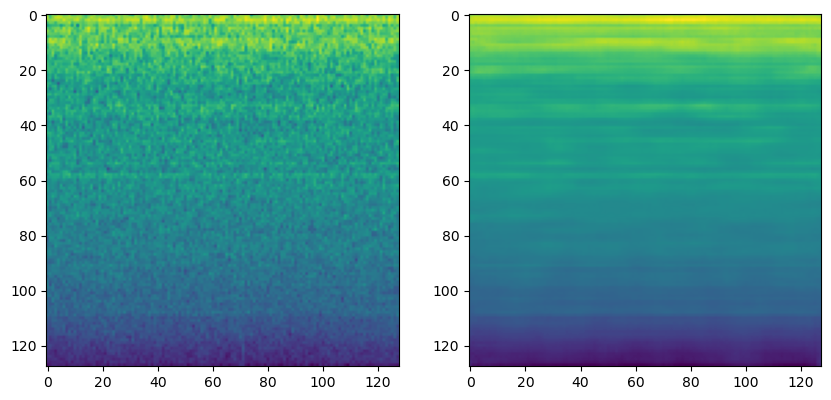

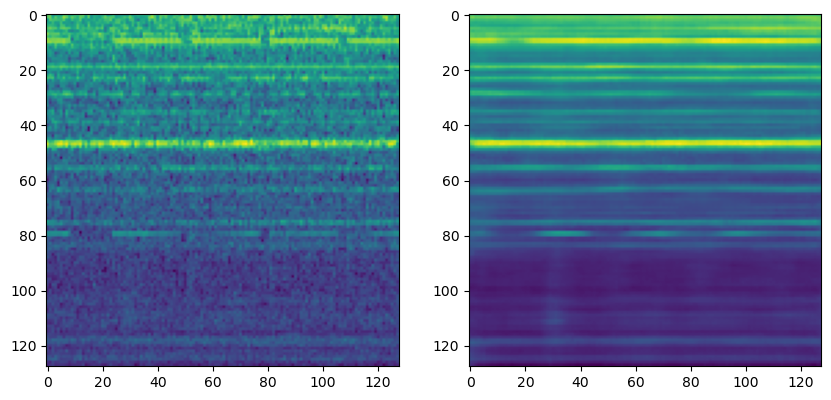

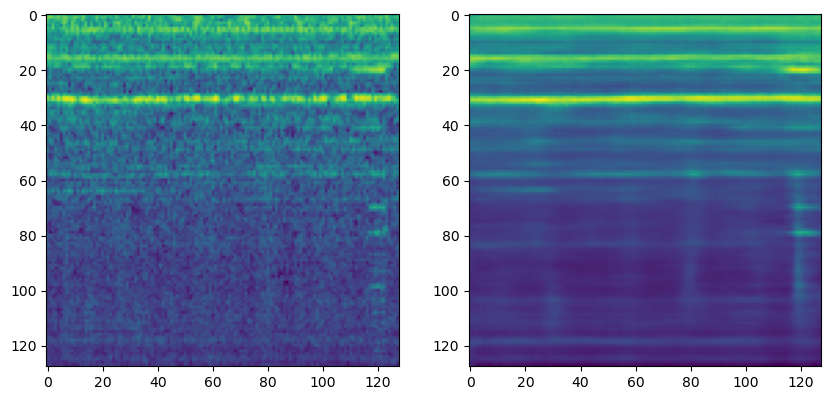

In [158]:
def show_some_predictions(dl, model, start_index, n_samples, image=False):
    shape = (-1, params.feature.n_mels, params.feature.n_mels) if image else (-1, 640)
    
    x, y = next(iter(dl))
    
    with torch.no_grad():
        yhat = model(x)
    
    x = x.cpu().numpy().reshape(shape)
    yhat = yhat.cpu().numpy().reshape(shape)
    print(x.shape, yhat.shape)
    
    for sample_idx in range(start_index, start_index + n_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        if image:
            axs[0].imshow(x[sample_idx])
            axs[1].imshow(yhat[sample_idx])
        else:
            axs[0].plot(x[sample_idx])
            axs[1].plot(yhat[sample_idx])

show_some_predictions(task2.train_dataloader(), task2.model.to(device), 0, 3, image=True)

# Testing on Development dataset

In [159]:
class DatasetCNNTest(DatasetCNN):
    def get_test_batch_x(self, file_index, n_mels=params.feature.n_mels, steps=20):
        log_mel_spectrogram = self.X[file_index]
        vector_array_size = (log_mel_spectrogram.shape[1] - n_mels + 1) // steps
        vector_array = np.zeros((vector_array_size, n_mels, n_mels))
        for t in range(vector_array_size):
            vector_array[t] = log_mel_spectrogram[:, t*steps:t*steps+n_mels]
        return vector_array

In [160]:
def file_to_vector_array_2d(file_name,
                         n_mels=128,
                         steps=20,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a 2d vector array.
    file_name : str
        target .wav file
    return : np.array( np.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 02 generate melspectrogram using librosa
    y, sr = com.file_load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vector_array_size = (log_mel_spectrogram.shape[1] - n_mels + 1) // steps

    # 06 generate feature vectors by concatenating multiframes
    vector_array = np.zeros((vector_array_size, n_mels, n_mels))
    for t in range(vector_array_size):
        vector_array[t] = log_mel_spectrogram[:, t*steps:t*steps+n_mels]

    return vector_array

In [161]:
def test_cnn():
    # make output result directory
    os.makedirs(params.result_directory, exist_ok=True)

    # load base directory
    dirs = com.select_dirs(param=params, mode=params.mode)
    
    csv_lines = []

    # PyTorch version specific...
    to_tensor = pytorch_common.ToTensor1ch(image=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # loop of the base directory
    for idx, target_dir in enumerate(dirs):
        # idx = 0
        print("\n===========================")
        print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
        machine_type = os.path.split(target_dir)[1] # slider

        print("============== MODEL LOAD ==============")
        # set model path
        model_file = "{model}/model_{machine_type}.pth".format(model=params.model_directory,
                                                               machine_type=machine_type)

        if not os.path.exists(model_file):
            com.logger.error("{} model not found ".format(machine_type))
            sys.exit(-1)
            
        com.logger.info("loading model: {}".format(model_file))
        
        model = CNNAE(skip_connections = params.skip_connection).to(device)
        
        pytorch_common.load_weights(model, model_file)
        
        model.eval()
        if params.mode: # if True, development data
            # results by type
            csv_lines.append([machine_type])
            csv_lines.append(["id", "AUC", "pAUC"])
            performance = []
        
        machine_id_list = get_machine_id_list_for_test(target_dir)
        print(machine_id_list)
        for id_str in machine_id_list:
            # load test file
            test_files, y_true = test_file_list_generator(target_dir, id_str, mode=params.mode)
            
            # setup anomaly score file path
            anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                                     result=params.result_directory,
                                                                                     machine_type=machine_type,
                                                                                     id_str=id_str)
            anomaly_score_list = []

            print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
            y_pred = [0. for k in test_files]
            for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
                try:
                    data_ = file_to_vector_array_2d(file_path,
                                                    n_mels=params.feature.n_mels,
                                                    n_fft=params.feature.n_fft,
                                                    hop_length=params.feature.hop_length,
                                                    power=params.feature.power)
                    data_ = pytorch_common.normalize_0to1(data_)
                    
                    with torch.no_grad():
                        yhat = model(to_tensor(data_)).cpu().detach().numpy().reshape(data_.shape)
                        errors = np.mean(np.square(data_ - yhat), axis=1)

                    y_pred[file_idx] = np.mean(errors)
                    
                    anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
                except:
                    com.logger.error("file broken!!: {}".format(file_path))
                    sys.exit(-1)

            # save anomaly score
            save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
            com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

            if params.mode:
                # append AUC and pAUC to lists
                auc = metrics.roc_auc_score(y_true, y_pred)
                p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=params.max_fpr)
                csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
                performance.append([auc, p_auc])
                com.logger.info("AUC : {}".format(auc))
                com.logger.info("pAUC : {}".format(p_auc))

            print("\n============ END OF TEST FOR A MACHINE ID ============")

        if params.mode:
            # calculate averages for AUCs and pAUCs
            averaged_performance = numpy.mean(numpy.array(performance, dtype=float), axis=0)
            csv_lines.append(["Average"] + list(averaged_performance))
            csv_lines.append([])

    if params.mode:
        # output results
        result_path = "{result}/{file_name}".format(result=params.result_directory, file_name=params.result_file)
        com.logger.info("AUC and pAUC results -> {}".format(result_path))
        save_csv(save_file_path=result_path, save_data=csv_lines)

test_cnn()

2023-05-30 14:55:54,563 - INFO - load_directory <- development
2023-05-30 14:55:54,563 - INFO - load_directory <- development
2023-05-30 14:55:54,563 - INFO - load_directory <- development
2023-05-30 14:55:54,563 - INFO - load_directory <- development
2023-05-30 14:55:54,563 - INFO - load_directory <- development
2023-05-30 14:55:54,563 - INFO - load_directory <- development
2023-05-30 14:55:54,563 - INFO - load_directory <- development
2023-05-30 14:55:54,571 - INFO - loading model: ./model/model_slider.pth
2023-05-30 14:55:54,571 - INFO - loading model: ./model/model_slider.pth
2023-05-30 14:55:54,571 - INFO - loading model: ./model/model_slider.pth
2023-05-30 14:55:54,571 - INFO - loading model: ./model/model_slider.pth
2023-05-30 14:55:54,571 - INFO - loading model: ./model/model_slider.pth
2023-05-30 14:55:54,571 - INFO - loading model: ./model/model_slider.pth
2023-05-30 14:55:54,571 - INFO - loading model: ./model/model_slider.pth
2023-05-30 14:55:54,609 - INFO - target_dir : /k


[1/1] /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider
============== MODEL LOAD ==============
['id_00', 'id_02', 'id_04']


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 456/456 [00:14<00:00, 32.38it/s]
2023-05-30 14:56:08,724 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-30 14:56:08,724 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-30 14:56:08,724 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-30 14:56:08,724 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-30 14:56:08,724 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-30 14:56:08,724 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-30 14:56:08,724 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2023-05-30 14:56:08,757 - INFO - AUC : 0.9890449438202247
2023-05-30 14:56:08,757 - INFO - AUC : 0.9890449438202247
2023-05-30 14:56:08,757 - INFO - AUC : 0.9890449438202247
2023-05-30 14:56:08,757 - INFO - AUC : 0.9890449438202247
2023-05-30 14:56:08,757 - INFO -


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 367/367 [00:10<00:00, 34.33it/s]
2023-05-30 14:56:19,519 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-30 14:56:19,519 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-30 14:56:19,519 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-30 14:56:19,519 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-30 14:56:19,519 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-30 14:56:19,519 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-30 14:56:19,519 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2023-05-30 14:56:19,550 - INFO - AUC : 0.778501872659176
2023-05-30 14:56:19,550 - INFO - AUC : 0.778501872659176
2023-05-30 14:56:19,550 - INFO - AUC : 0.778501872659176
2023-05-30 14:56:19,550 - INFO - AUC : 0.778501872659176
2023-05-30 14:56:19,550 - INFO - AUC


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:08<00:00, 33.22it/s]
2023-05-30 14:56:28,001 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-30 14:56:28,001 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-30 14:56:28,001 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-30 14:56:28,001 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-30 14:56:28,001 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-30 14:56:28,001 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-30 14:56:28,001 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2023-05-30 14:56:28,024 - INFO - AUC : 0.9458988764044943
2023-05-30 14:56:28,024 - INFO - AUC : 0.9458988764044943
2023-05-30 14:56:28,024 - INFO - AUC : 0.9458988764044943
2023-05-30 14:56:28,024 - INFO - AUC : 0.9458988764044943
2023-05-30 14:56:28,024 - INFO -


============ END OF TEST FOR A MACHINE ID ============


In [162]:
def upto_6digits(cell):
    if not cell[0].isdigit(): return cell
    return f'{float(cell):.6f}'

if params.mode:
    with open('./result/result.csv') as f:
        for l in f.readlines():
            l = l.strip() #replace('\n', '')
            if ',' not in l:
                print(l)
                continue
            ls = l.split(',')
            print(f'{ls[0]}\t\t{upto_6digits(ls[1])}\t\t{upto_6digits(ls[2])}')

slider
id		AUC		pAUC
00		0.989045		0.942933
02		0.778502		0.583481
04		0.945899		0.772620
Average		0.904482		0.766345



# Testing on the Evaluation dataset and generating submission file

In [163]:
# re-training on evaluation dataset
params.mode = False

task2 = train_cnnae() # due to the memory restriction, restart the kernel and train on only evaluation dataset

==== Start training [slider] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
             ReLU-12            [-1, 256, 7, 7]               0
          Dropout-13            [-1, 256, 7, 7]       

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

2023-05-30 14:56:28,476 - INFO - Creating Val
2023-05-30 14:56:28,476 - INFO - Creating Val
2023-05-30 14:56:28,476 - INFO - Creating Val
2023-05-30 14:56:28,476 - INFO - Creating Val
2023-05-30 14:56:28,476 - INFO - Creating Val
2023-05-30 14:56:28,476 - INFO - Creating Val
2023-05-30 14:56:28,476 - INFO - Creating Val
2023-05-30 14:56:28,497 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:56:28,497 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:56:28,497 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:56:28,497 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:56:28,497 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:56:28,497 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:56:28,497 - INFO - Created the  dataset shape ((237, 128, 313))
2023-05-30 14:56:36,746 - INFO - End Val
2023-05-30 14:56:36,746 - INFO - End Val
2023-05-30 14:56:36,746 - INFO - End Val
2023-05-3

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

saved ./model/model_slider.pth.



2023-05-30 15:08:40,715 - INFO - Creating Train
2023-05-30 15:08:40,715 - INFO - Creating Train
2023-05-30 15:08:40,715 - INFO - Creating Train
2023-05-30 15:08:40,715 - INFO - Creating Train
2023-05-30 15:08:40,715 - INFO - Creating Train
2023-05-30 15:08:40,715 - INFO - Creating Train
2023-05-30 15:08:40,715 - INFO - Creating Train
2023-05-30 15:08:40,787 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 15:08:40,787 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 15:08:40,787 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 15:08:40,787 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 15:08:40,787 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 15:08:40,787 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 15:08:40,787 - INFO - Created the  dataset shape ((2133, 128, 313))
2023-05-30 15:09:52,786 - INFO - End Train
2023-05-30 15:09:52,786 - INFO - End Train
2023-05-30 15:09:52,786 -

(64, 128, 128) (64, 128, 128)


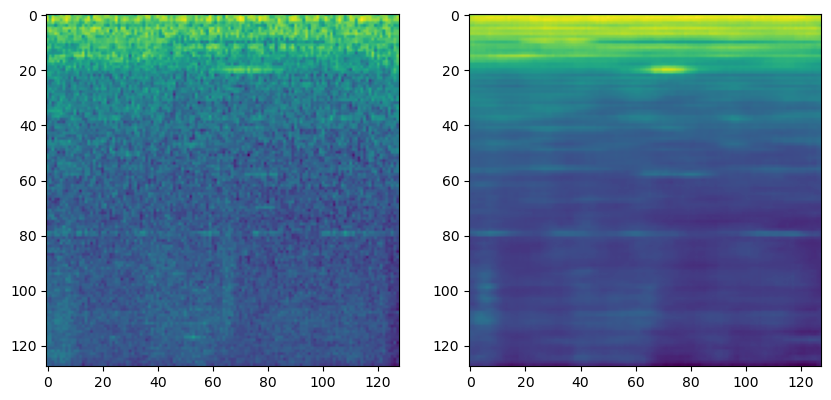

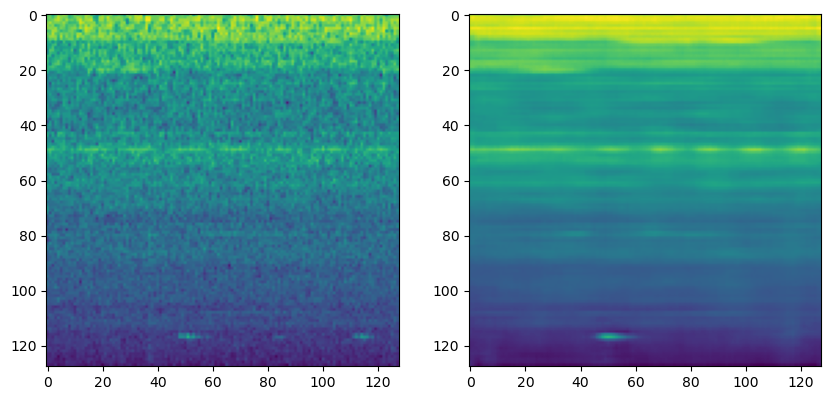

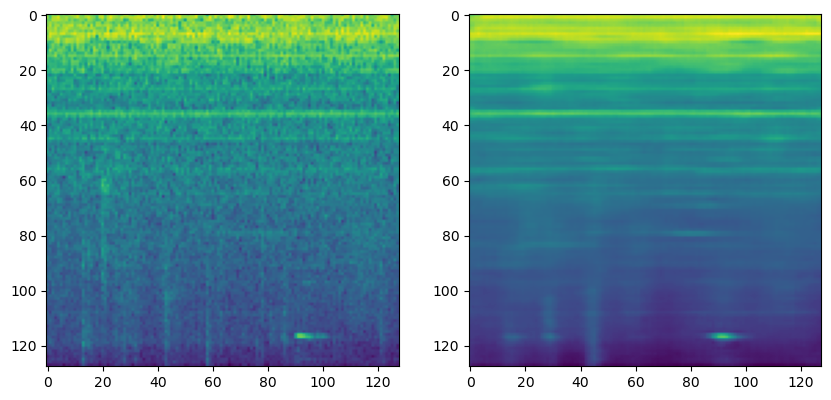

In [164]:
def show_some_predictions(dl, model, start_index, n_samples, image=False):
    shape = (-1, params.feature.n_mels, params.feature.n_mels) if image else (-1, 640)
    
    x, y = next(iter(dl))
    
    with torch.no_grad():
        yhat = model(x)
    
    x = x.cpu().numpy().reshape(shape)
    yhat = yhat.cpu().numpy().reshape(shape)
    print(x.shape, yhat.shape)
    
    for sample_idx in range(start_index, start_index + n_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        if image:
            axs[0].imshow(x[sample_idx])
            axs[1].imshow(yhat[sample_idx])
        else:
            axs[0].plot(x[sample_idx])
            axs[1].plot(yhat[sample_idx])
            
show_some_predictions(task2.train_dataloader(), task2.model.to(device), 0, 3, image=True)


In [165]:
test_cnn()


2023-05-30 15:09:54,590 - INFO - load_directory <- evaluation
2023-05-30 15:09:54,590 - INFO - load_directory <- evaluation
2023-05-30 15:09:54,590 - INFO - load_directory <- evaluation
2023-05-30 15:09:54,590 - INFO - load_directory <- evaluation
2023-05-30 15:09:54,590 - INFO - load_directory <- evaluation
2023-05-30 15:09:54,590 - INFO - load_directory <- evaluation
2023-05-30 15:09:54,590 - INFO - load_directory <- evaluation
2023-05-30 15:09:54,601 - INFO - loading model: ./model/model_slider.pth
2023-05-30 15:09:54,601 - INFO - loading model: ./model/model_slider.pth
2023-05-30 15:09:54,601 - INFO - loading model: ./model/model_slider.pth
2023-05-30 15:09:54,601 - INFO - loading model: ./model/model_slider.pth
2023-05-30 15:09:54,601 - INFO - loading model: ./model/model_slider.pth
2023-05-30 15:09:54,601 - INFO - loading model: ./model/model_slider.pth
2023-05-30 15:09:54,601 - INFO - loading model: ./model/model_slider.pth
2023-05-30 15:09:54,634 - INFO - target_dir : /kaggle/i


[1/1] /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider
============== MODEL LOAD ==============
['id_01', 'id_03', 'id_05']


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:08<00:00, 34.44it/s]
2023-05-30 15:10:02,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-30 15:10:02,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-30 15:10:02,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-30 15:10:02,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-30 15:10:02,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-30 15:10:02,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-30 15:10:02,730 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2023-05-30 15:10:02,752 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_03
2023-05-30 15:10:02,752 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_03
2023-05-30 15:10:02,


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:08<00:00, 33.57it/s]
2023-05-30 15:10:11,070 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-30 15:10:11,070 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-30 15:10:11,070 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-30 15:10:11,070 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-30 15:10:11,070 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-30 15:10:11,070 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-30 15:10:11,070 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2023-05-30 15:10:11,086 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_05
2023-05-30 15:10:11,086 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_05
2023-05-30 15:10:11,


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:08<00:00, 31.55it/s]
2023-05-30 15:10:19,928 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv
2023-05-30 15:10:19,928 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv
2023-05-30 15:10:19,928 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv
2023-05-30 15:10:19,928 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv
2023-05-30 15:10:19,928 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv
2023-05-30 15:10:19,928 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv
2023-05-30 15:10:19,928 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv



============ END OF TEST FOR A MACHINE ID ============


In [168]:
import numpy as np
import pandas as pd

df1 = pd.read_csv('./result/anomaly_score_slider_id_01.csv', delimiter=',', header=None)
df3 = pd.read_csv('./result/anomaly_score_slider_id_03.csv', delimiter=',', header=None)
df5 = pd.read_csv('./result/anomaly_score_slider_id_05.csv', delimiter=',', header=None)

dfs = [df1, df3, df5]
eval_df = pd.concat(dfs)
eval_df = eval_df.rename(columns={0: "file_name", 1: "anomaly_score"})

eval_df.to_csv('/kaggle/working/submission6.csv',index = False)


In [167]:
eval_df.head()


,file_name,anomaly_score
0,id_01_00000000.wav,0.000933
1,id_01_00000001.wav,0.000696
2,id_01_00000002.wav,0.000692
3,id_01_00000003.wav,0.000719
4,id_01_00000004.wav,0.000864
